**Legenda:**     #ReadMe

Using checkpoint, called automatically using 'RunEnd', the training run all the epochs keeping the best model, we do it in order to make fair comparisons.

The idea is to compare different augmentation and batch with fixed epochs. In conclusion we increase the epochs value, while using callbacks.

The last part is to test the model on another split of the data, in order to check if it is too correlated with its former split.

Usando il checkpoint, che parte in automatico chiamando 'RunEnd', il training runna tutte le epoche e tiene il miglior modello, serve per fare dei confronti sensati.

L'idea è di fare i vari confronti con augmentation e batch con le epoche fissate (poi si tira fuori il miglior risultato di quelle fatte).
Infine si aumenta il valore delle epochs, si da un valore a callbacks e si crea un modello che poi si salva.

(Tutto questo dovrebbe già essere automatizzato, basta modificare 'Set patameters' e fare esegui tutte)

P.s. fate attenzione a duplicare questi notebook che sono un po' suscettibili.

In fondo c'è una sezione in più "train on different data" questo è fatto per provare a trainare il modello su un'altra partizione dei dati, in questo modo possiamo verificare che i risultati non siano troppo influezati da questa partizione. (attenzione a non fare testing dei modelli ritrainati sulla partizione salvata nella cartella, non sarebbe indipendente)

Dopo aver salvato il modello, spostatelo in 'Models storage' di modo da non rischiare di sovrascrive.
(In quella cartella si possono confrontare i diversi modelli trainati fino ad adesso, solo quelli trainati sulla partizione test/train dentro la cartella TUNING)

Inoltre la definizione dei modelli che salvati, copiamola in una nuova code cell, nel notebook 'script models'

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Challenge1/TUNING

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1hzamFV4kC27mUMEV9YGWnQmv2-k5TZvo/Challenge1/TUNING


In [ ]:
# librerie prova, quelle da codalab
import tensorflow as tf
import Cython
import numpy as np
import matplotlib
import seaborn as sns
import scipy
#import scikit_learn
#import scikit_image
import pandas as pd
#import pyyaml
import imutils
#import opencv-python
import tqdm
import psutil
import h5py

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)


from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model

import shutil #to delete a folder in the cd

2.14.0


In [ ]:
#pip install keras_cv

In [ ]:
#import keras_cv

# Set parameters

In [ ]:
#Set Epochs
epochs = 500

In [ ]:
#Da non modificare

Batch=np.empty(0)
Callbacks= np.empty(0)
Preprocessing = np.empty(0)
Dropout = np.empty(0)

In [ ]:
#Set Batch
batch_size=100

#togliere il commento a questo solo per far andare la sezione 'tune batch'
#Batch = np.array([110,130])

In [ ]:
#Set Augmentation

#Example
preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.25, value_range=(0,1)),
        #tfkl.RandomContrast(0.8),
        #tfkl.RandomTranslation(0.4,0.4),
        #tfkl.RandomRotation(0.1)
        ], name='preprocessing')


preprocessing1 = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical"),
        tfkl.RandomZoom(0.4)
        ], name='preprocessing')

preprocessing2 = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical"),
        tfkl.RandomRotation(0.1)
        ], name='preprocessing')

preprocessing3 = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical"),
        tfkl.RandomTranslation(0.4,0.4)
        ], name='preprocessing')



#togliere il commento a questo solo per far andare la sezione 'tune Augmentation'
Preprocessing=np.array([preprocessing1, preprocessing2, preprocessing3])

#nomi delle augmentation
PREPRO = np.array (['flip+zoom','flip+rot','flip+transl'])

In [ ]:
#Set Callbacks


early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True, mode='auto', start_from_epoch=70)

lr_decay = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=20, min_lr=1e-4, mode='max')
callback1=[ early_stopping, lr_decay ]

callback2= tfk.callbacks.EarlyStopping(monitor='precision', patience=25, restore_best_weights=True, mode='max')


#togliere il commento a questo solo per far andare la sezione 'tune Callbacks'
#Callbacks=np.array([ [early_stopping], callback1, [callback2] ])

#nomi delle varie iterazioni
CALLB = np.array(['normal', 'decay', 'precision'])


callbacks = early_stopping


In [ ]:
#Set Dropout
dropout_rate = 1/6

#togliere il commento a questo solo per far andare la sezione 'tune Dropout'
#Dropout=np.array([1/4,1/6, 1/8])

# Import data and Define model

In [ ]:
#IMPORT
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
labels = {0:'healthy', 1:'unhealthy'}

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

In [ ]:
#Baseline + Preprocessing

def build_model(preprocessing, dropout_rate,input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)


    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    pre = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(pre)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496   

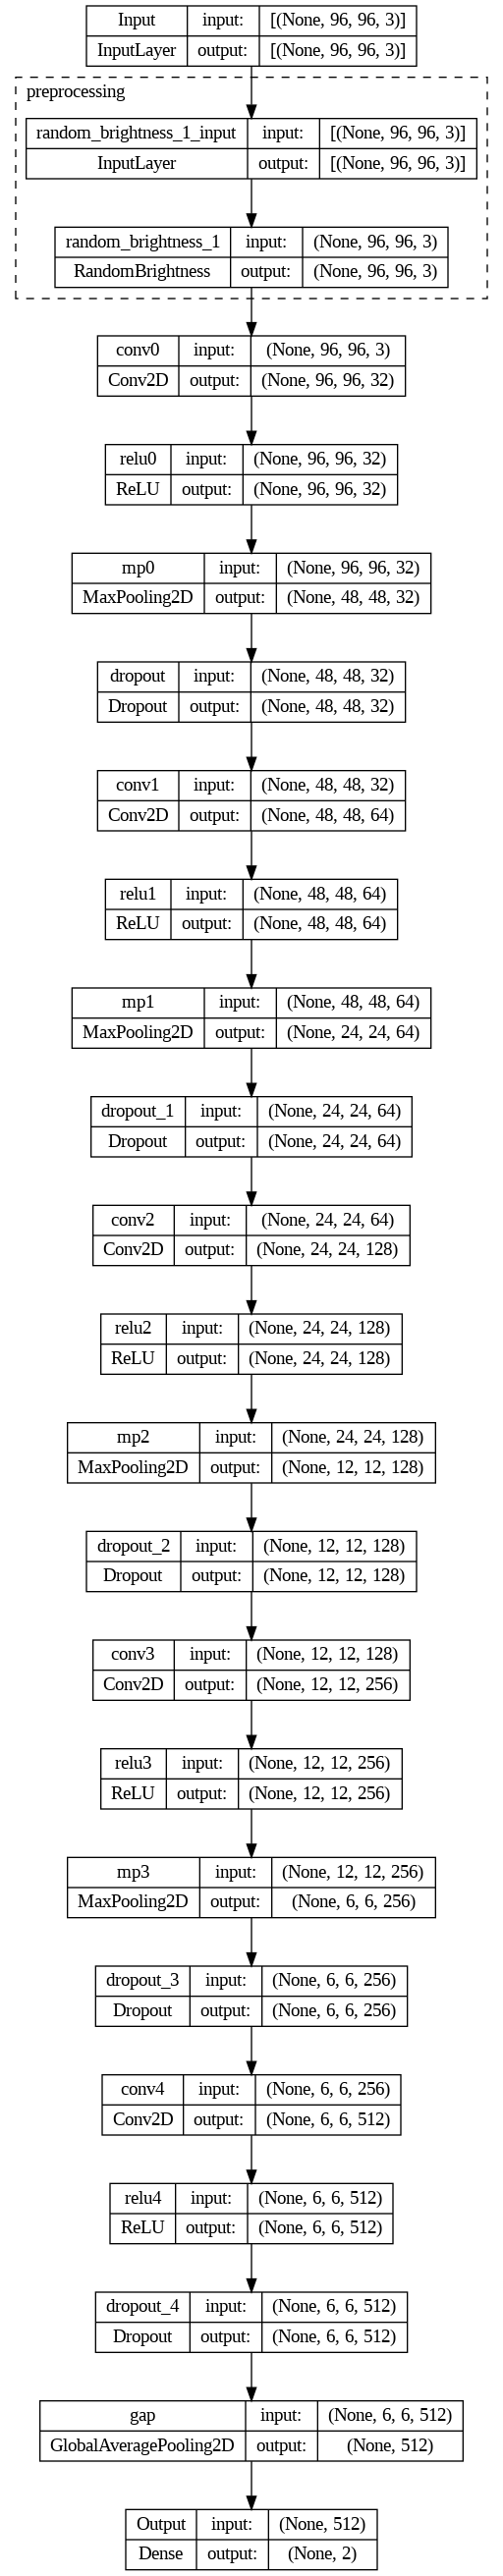

In [ ]:
model=build_model(preprocessing,dropout_rate)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

# Augmentation Tuning


In [ ]:
if len(Preprocessing) != 0 :
  Size= Preprocessing.size
  Train = np.zeros(Size)
  Val = np.zeros(Size)
  Test= np.zeros(Size)
  Epoche = np.zeros(Size)

In [ ]:
if len(Preprocessing) != 0 :
  for i in range(Size):
    i=i+1

    print("\nStart test:", i+1, "   Preprocessing:", PREPRO[i])
    preprocessing=Preprocessing[i]

    del model
    model=build_model(preprocessing,dropout_rate)

    %run ./RunA.ipynb

    Train[i]=train_accuracy
    Val[i]=val_accuracy
    Test[i]=test_accuracy
    Epoche[i]=len(history['loss'])
    model.save('aaa')

    if i==0 or Test[i]>=np.max(Test):
      print('\nTest', i+1, 'is the best so far\n')
      LOSS=history['loss']
      VALLOSS=history['val_loss']
      ACC=history['accuracy']
      VALACC=history['val_accuracy']
      BestModel=model


Start test: 2    Preprocessing: flip+rot
Epoch 1/500
32/32 [==============================] - 5s 67ms/step - loss: 0.6904 - accuracy: 0.6119 - val_loss: 0.6699 - val_accuracy: 0.6206
Epoch 2/500
32/32 [==============================] - 2s 53ms/step - loss: 0.6654 - accuracy: 0.6201 - val_loss: 0.6627 - val_accuracy: 0.6206
Epoch 3/500
32/32 [==============================] - 2s 54ms/step - loss: 0.6667 - accuracy: 0.6201 - val_loss: 0.6615 - val_accuracy: 0.6206
Epoch 4/500
32/32 [==============================] - 2s 60ms/step - loss: 0.6608 - accuracy: 0.6201 - val_loss: 0.6546 - val_accuracy: 0.6206
Epoch 5/500
32/32 [==============================] - 2s 58ms/step - loss: 0.6495 - accuracy: 0.6364 - val_loss: 0.6572 - val_accuracy: 0.6872
Epoch 6/500
32/32 [==============================] - 2s 59ms/step - loss: 0.6339 - accuracy: 0.6725 - val_loss: 0.6483 - val_accuracy: 0.6382
Epoch 7/500
32/32 [==============================] - 2s 56ms/step - loss: 0.6116 - accuracy: 0.6870 - val_

IndexError: ignored

In [ ]:
if len(Preprocessing) != 0 :
  ind = np.argmax(Test)

  #SET best
  preprocessing=Preprocessing[ind]
  print('Best preprocessing', PREPRO[ind], '\n')

  # Display the computed metrics
  print('Training Accuracy:', Train[ind].round(4))
  print('Validation Accuracy:', Val[ind].round(4))
  print('Test Accuracy:', Test[ind].round(4))


if len(Preprocessing) != 0 :
  plt.figure(figsize=(15,5))
  plt.plot(PREPRO, Train, label='Train', alpha=.5, color='#ff7f0e')
  plt.plot(PREPRO, Val, label='Val', alpha=.8, color='#d62728')
  plt.plot(PREPRO, Test, label='Test', alpha=1, color='#1f77b4')
  plt.legend(loc='upper left')
  plt.grid(alpha=.3)
  plt.xticks(PREPRO)  # Set custom x-axis values
  plt.xlabel('Callbacks')  # Set x-axis label
  plt.ylabel('Accuracy')  # Set y-axis label

In [ ]:
if len(Preprocessing) != 0 :
  for i in range(Size):
    print("Preprocessing:", PREPRO[i], '     Train:', Train[i].round(4), ' Val:', Val[i].round(4), 'Test:', Test[i].round(4), '  Epochs:', Epoche[i])

In [ ]:
if len(Preprocessing) != 0 :
  # Plot best training
  print('Plot best training')
  plt.figure(figsize=(15,5))
  plt.plot(LOSS, alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(VALLOSS, label='Vanilla CNN', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(15,5))
  plt.plot(ACC, alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(VALACC, label='Vanilla CNN', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()

# Tune Batch and Run

In [ ]:
if len(Batch) != 0 :
  Size= Batch.size
  Train = np.zeros(Size)
  Val = np.zeros(Size)
  Test= np.zeros(Size)
  Epoche = np.zeros(Size)

In [ ]:
if len(Batch) != 0 :
  for i in range(Size):

    print("\nStart test:", i+1, "   Batch:", Batch[i])
    batch_size = Batch[i]

    del model
    model=build_model(preprocessing,dropout_rate)

    %run ./RunA.ipynb

    Train[i]=train_accuracy
    Val[i]=val_accuracy
    Test[i]=test_accuracy
    Epoche[i]=len(history['loss'])

    if i==0 or Test[i]>=np.max(Test):
      print('\nTest', i+1, 'is the best so far\n')
      LOSS=history['loss']
      VALLOSS=history['val_loss']
      ACC=history['accuracy']
      VALACC=history['val_accuracy']
      BestModel=model

In [ ]:
if len(Batch) != 0 :
  ind = np.argmax(Test)

  #SET Best Batch
  batch_size=Batch[ind]
  print('Best batch size', batch_size, '\n')

  # Display the computed metrics
  print('Training Accuracy:', Train[ind].round(4))
  print('Validation Accuracy:', Val[ind].round(4))
  print('Test Accuracy:', Test[ind].round(4))

  # Plot the training
  plt.figure(figsize=(15,5))
  plt.plot(Batch, Train, label='Train', alpha=.5, color='#ff7f0e')
  plt.plot(Batch, Val, label='Val', alpha=.8, color='#d62728')
  plt.plot(Batch, Test, label='Test', alpha=1, color='#1f77b4')
  plt.legend(loc='upper left')
  plt.grid(alpha=.3)
  plt.xticks(Batch)  # Set custom x-axis values
  plt.xlabel('Batch size')  # Set x-axis label
  plt.ylabel('Accuracy')  # Set y-axis label

  #other color='#17becf'

In [ ]:
if len(Batch) != 0 :
  for i in range(Size):
    print("Batch Size:", Batch[i], '     Train:', Train[i].round(4), ' Val:', Val[i].round(4), 'Test:', Test[i].round(4), '  Epochs:', Epoche[i])

In [ ]:
if len(Batch) != 0 :
  # Plot best training
  print('Plot best training')
  plt.figure(figsize=(15,5))
  plt.plot(LOSS, alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(VALLOSS, label='Vanilla CNN', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(15,5))
  plt.plot(ACC, alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(VALACC, label='Vanilla CNN', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()

# Tune callback and decay

In [ ]:
if len(Callbacks) != 0 :
  Size= Callbacks.size
  Train = np.zeros(Size)
  Val = np.zeros(Size)
  Test= np.zeros(Size)
  Epoche = np.zeros(Size)

In [ ]:
if len(Callbacks) != 0 :
  for i in range(Size):

    callbacks = Callbacks[i]
    print("\nStart test:", i+1, "   Callback:", CALLB[i])

    del model
    model=build_model(preprocessing,dropout_rate)

    %run ./RunA.ipynb

    Train[i]=train_accuracy
    Val[i]=val_accuracy
    Test[i]=test_accuracy
    Epoche[i]=len(history['loss'])

    if i==0 or Test[i]>=np.max(Test):
      print('\nTest', i+1, 'is the best so far\n')
      LOSS=history['loss']
      VALLOSS=history['val_loss']
      ACC=history['accuracy']
      VALACC=history['val_accuracy']
      BestModel=model

In [ ]:
if len(Callbacks) != 0 :
  ind = np.argmax(Test)

  #SET Best Batch
  callbacks=Callbacks[i]
  print('Best callback: ', CALLB[ind], '\n')

  # Display the computed metrics
  print('Training Accuracy:', Train[ind].round(4))
  print('Validation Accuracy:', Val[ind].round(4))
  print('Test Accuracy:', Test[ind].round(4))

  # Plot the training
  plt.figure(figsize=(15,5))
  plt.plot(CALLB, Train, label='Train', alpha=.5, color='#ff7f0e')
  plt.plot(CALLB, Val, label='Val', alpha=.8, color='#d62728')
  plt.plot(CALLB, Test, label='Test', alpha=1, color='#1f77b4')
  plt.legend(loc='upper left')
  plt.grid(alpha=.3)
  plt.xticks(CALLB)  # Set custom x-axis values
  plt.xlabel('Callbacks')  # Set x-axis label
  plt.ylabel('Accuracy')  # Set y-axis label

  #other color='#17becf'

In [ ]:
if len(Callbacks) != 0 :
  #Callback: precision   Train: 0.9246  Val: 0.8681 Test: 0.871   Epochs: 200.0
  for i in range(Size):
    print("Callback:", CALLB[i], '  Train:', Train[i].round(4), ' Val:', Val[i].round(4), 'Test:', Test[i].round(4), '  Epochs:', Epoche[i])

In [ ]:
if len(Callbacks) != 0 :
  # Plot best training
  print('Plot best training')
  plt.figure(figsize=(15,5))
  plt.plot(LOSS, alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(VALLOSS, label='Vanilla CNN', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(15,5))
  plt.plot(ACC, alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(VALACC, label='Vanilla CNN', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()

# Dropout tuning

In [ ]:
if len(Dropout) != 0 :
  Size= Dropout.size
  Train = np.zeros(Size)
  Val = np.zeros(Size)
  Test= np.zeros(Size)
  Epoche = np.zeros(Size)

In [ ]:
if len(Dropout) != 0 :
  for i in range(Size):

    print("\nStart test:", i+1, "   Dropout:", Dropout[i])
    dropout_rate = Dropout[i]

    del model
    model=build_model(preprocessing,dropout_rate)

    %run ./RunA.ipynb

    Train[i]=train_accuracy
    Val[i]=val_accuracy
    Test[i]=test_accuracy
    Epoche[i]=len(history['loss'])

    if i==0 or Test[i]>=np.max(Test):
      print('\nTest', i+1, 'is the best so far\n')
      LOSS=history['loss']
      VALLOSS=history['val_loss']
      ACC=history['accuracy']
      VALACC=history['val_accuracy']
      BestModel=model

In [ ]:
if len(Dropout) != 0 :
  ind = np.argmax(Test)

  #SET Best Dropout
  dropout_rate=Dropout[ind]
  print('Best Dropout rate', dropout_rate, '\n')

  # Display the computed metrics
  print('Training Accuracy:', Train[ind].round(4))
  print('Validation Accuracy:', Val[ind].round(4))
  print('Test Accuracy:', Test[ind].round(4))

  # Plot the training
  plt.figure(figsize=(15,5))
  plt.plot(Dropout, Train, label='Train', alpha=.5, color='#ff7f0e')
  plt.plot(Dropout, Val, label='Val', alpha=.8, color='#d62728')
  plt.plot(Dropout, Test, label='Test', alpha=1, color='#1f77b4')
  plt.legend(loc='upper left')
  plt.grid(alpha=.3)
  plt.xticks(Dropout)  # Set custom x-axis values
  plt.xlabel('Dropout Rate')  # Set x-axis label
  plt.ylabel('Accuracy')  # Set y-axis label

  #other color='#17becf'

In [ ]:
if len(Dropout) != 0 :
  for i in range(Size):
    print("Dropout Rate:", Dropout[i], '     Train:', Train[i].round(4), ' Val:', Val[i].round(4), 'Test:', Test[i].round(4), '  Epochs:', Epoche[i])

In [ ]:
if len(Dropout) != 0 :
  # Plot best training
  print('Plot best training')
  plt.figure(figsize=(15,5))
  plt.plot(LOSS, alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(VALLOSS, label='Vanilla CNN', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(15,5))
  plt.plot(ACC, alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(VALACC, label='Vanilla CNN', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()

# SAVE

In [ ]:
BestModel.save('simo2')

# Score

In [ ]:
print('Batch:', batch_size, '  Augmentation:', preprocessing, '  Callback:', callbacks, '  Dropout:', dropout_rate)

In [ ]:
# Predict labels for the entire test set
#BestModel = tfk.models.load_model('Flip+Trasl')

predictions = BestModel.predict(X_test, verbose=0)
predicted=np.argmax(predictions, axis=-1)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (442, 2)


In [ ]:
# Compute classification metrics
train_pred=np.argmax(BestModel.predict(X_train, verbose=0), axis=-1)
train_accuracy = accuracy_score(y_train[:,1], train_pred)
val_pred=np.argmax(BestModel.predict(X_val, verbose=0), axis=-1)
val_accuracy = accuracy_score(y_val[:,1], val_pred)
test_accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted, average='macro')
recall = recall_score(y_test, predicted, average='macro')
f1 = f1_score(y_test, predicted, average='macro')

# Display the computed metrics
print('Training Accuracy:', train_accuracy.round(4))
print('Validation Accuracy:', val_accuracy.round(4))
print('Test Accuracy:', test_accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Training Accuracy: 0.9378
Validation Accuracy: 0.8957
Test Accuracy: 0.8688
Precision: 0.8599
Recall: 0.8631
F1: 0.8614


# Train on different Train

In [ ]:
'''X_train_val = np.load('X_train_val.npy')
y_train_val = np.load('y_train_val.npy')

seed=43

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.2,
    random_state = seed,
    stratify = y_train_val
)

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]'''

del model
model=build_model(preprocessing,dropout_rate)
%run ./RunA.ipynb

model1=model

In [ ]:
print('Train:',train_accuracy.round(4),'  Val:',val_accuracy.round(4),'  Test:',test_accuracy.round(4),'  Epoche:',len(history['loss']))

In [ ]:
model1.save('AndreBase')

# Train with different test

In [ ]:
Xn = np.load('X.npy')
Yn = np.load('Y.npy')

seed=44

Xn_train_val, X_test, yn_train_val, y_test = train_test_split(
    Xn,
    Yn,
    test_size = 0.2,
    random_state = seed,
    stratify = Yn
)

X_train, X_val, y_train, y_val = train_test_split(
    Xn_train_val,
    yn_train_val,
    test_size = 0.2,
    random_state = seed,
    stratify = yn_train_val
)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

del model
model=build_model(preprocessing,dropout_rate)
%run ./RunA.ipynb

model2=model

In [ ]:
print('Train:',train_accuracy.round(4),'  Val:',val_accuracy.round(4),'  Test:',test_accuracy.round(4),'  Epoche:',len(history['loss']))